# **Lecture Draft: Why Study GDP?**

This lecture will use Python, pandas, and matplotlib to introduce GDP as an economic concept by identifying some of the factors using correlations.

In [3]:
!pip install wbgapi
!pip install pandas-datareader

     |████████████████████████████████| 109 kB 2.7 MB/s eta 0:00:01


In [14]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np
from collections import namedtuple
import datetime
import pandas_datareader.data as web
import scipy.optimize

import plotly.express as px

import wbgapi as wb

import pandas_datareader.data as web

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
# Set the working directory
os.chdir("/content/drive/MyDrive/gdp_lecture")

# 1 What is GDP

## 1.1 Overview

Gross Domestic Product (`GDP`) is the primary indicator used to exmine the economic performance of a country, measuring the total market value of all goods and services produced within a country over a specified period.

GDP is usually analysed in two forms: Nominal GDP, which is valued at current market prices, and Real GDP, which is adjusted for inflation to reflect the true economic growth. Nominal GDP can be adjust to Real GDP using the formula: `Real GDP = Nominal GDP x (Price level in base year ÷ Price level in current year)`.

The following graph presents a visual comparison between Nominal GDP and Real GDP per quarter over time in the United States:


In [ ]:
start_date = datetime.datetime(2017, 4, 1)
end_date = datetime.datetime(2024, 1, 1)

nominal_gdp = web.DataReader('GDP', 'fred', start_date, end_date)
real_gdp = web.DataReader('GDPC1', 'fred', start_date, end_date)

plt.figure(figsize=(10, 6))
plt.plot(nominal_gdp.index, nominal_gdp['GDP'], label='Nominal GDP')
plt.plot(real_gdp.index, real_gdp['GDPC1'], label='Real GDP', linestyle='--')

plt.title('Nominal vs. Real GDP of US (1949 - 2023)')
plt.xlabel('Year')
plt.ylabel('Billions of Dollars / Billions of Chained 2017 Dollars')
plt.legend()
plt.show()

Source: Federal Reserve Economic Data (St. Louis Fed)

Real GDP is measured in "billions of chained 2017 dollars",which is a dollar measure that is adjusted for the price change due to inflation and consumer behaviour within the year of 2017. Here are some interesting observations:

- Both Nominal and Real GDP displayed increasing trend since 2017.
- Nominal GDP growth outpaced Real GDP indicating inflation's role as a contributing factor.
- 2020 saw GDP drops due to the COVID-19 pandemic, respectively. This crisis led to significant GDP contractions, evident in downturn around 2020 on the graph.

## 1.2 GDP vs. GDP per Capita

GDP per capita can be calculated using the formula `GDP per capita = GDP ÷ population`.

GDP per capital is often a more useful indicator of economic well-being and quality of life. This adjustment also allows comparison of economic well-being across countries with vastly different population sizes.

Consider the following graph of GDP per capita vs. GDP of most countries:  

In [ ]:
wb.series.info(q='GDP')

In [ ]:
data = pd.read_excel('GDP.xlsx', sheet_name='Full Data')

fig = px.scatter(data, x='GDP per capita', y='GDP',
                 hover_name='Country Name', title='GDP per capita vs GDP')


fig.update_layout(
    xaxis_title="GDP per capita ($ thousands)",
    yaxis_title="GDP ($ trillians)"
)


fig.show()

Source: The World Bank

From this graph, we can see that:
- A country may have a high total GDP due to its large size but a moderate GDP per capita, for example India,
- Similarly, a country may have a low overal GDP due limited size but a high GDP per capital level driven by high production level, for example Liechtenstein and Monaco

## 1.3 GDP: Ways of Calculation

GDP can be calculated using three main methods: the Expenditure Method, the Income Method, and the Output Method. Each approach focuses on a different aspect of the economy's total output and income. However, in theory, all three should arrive at the same GDP figure, reflecting the circular flow of income in the economy.

### 1.3.1 Expenditure Method

The expenditure method calculates GDP by summing up all expenditures made on final goods and services, i.e. ones that will not be sold again as part of other goods or services, over a specific period. The formula is represented as: `GDP = C + I + G + (X - M)`

where:
- `C` stands for consumption by households,
- `I` represents investment by firms,
- `G` is government spending,
- `X` represents exports, and
- `M` stands for imports (`X - M` is net exports).



### 1.3.2 Income Method

The income method approaches GDP calculation by summing all incomes generated by factors of production in the economy, including wages, interest, rent, and profits. The formula can be presented as: `GDP = Total National Income + Sales Taxes + Depreciation + Net Foreign Factor Income`

where
- `Total National Income` is the sum of wages, interest, rent, and profits earned,
- `Sales Taxes` are taxes imposed on sales of goods and services,
- `Depreciation` is the wear and loose of value on physical assets over time,
- `Net Foreign Factor Income` is the difference between the income a nation receive from foreign countries – payments to made foreign entities


### 1.3.3 Output/Production Method

This method calculates GDP by adding up the value added at each stage of production across all industries. The value added at each stage is the sale price minus the cost of inputs. For example, in the production of bread:
- The farmer grows wheat and sells it at a value added of 0.1.
- The mill buys the wheat and produces flour, adding value of 0.4.
- The baker uses the flour to make bread, adding value of 1.0.
- The store sells the bread, adding a final value of 1.5.

The total GDP using this method would be the sum of all value added, which in this case is 0.1+0.4+1.0+1.5 = 3.0.

The follow table illustrates this method in a clearer way:

In [ ]:
data = {
    'Stage': ['Farmer', 'Mill', 'Baker', 'Store'],
    'Costs': [0, 0.1, 0.5, 1.5],
    'Sale Price': [0.1, 0.5, 1.5, 3.0],
    'Value Added': [0.1, 0.4, 1.0, 1.5]
}

df = pd.DataFrame(data)


total_value_added = df['Value Added'].sum()

total_df = pd.DataFrame([{'Stage': 'Total', 'Costs': '-', 'Sale Price': '-', 'Value Added': total_value_added}])

df_final = pd.concat([df, total_df], ignore_index=True)

print(df_final.to_string(index=False))


## 1.4 Expenditure Method: Components of GDP vs. GDP Per Capita as Correlations

The collection and preprocessing of the csv files ("gdp_components.csv" and "gdp_components_2.csv") can be found here.

In [ ]:
gdp_components = pd.read_csv('/content/drive/MyDrive/gdp_components_income.csv')

#### 1.4.1 Components of GDP for User-Selected Country

In [ ]:
def components_of_gdp(country):
    df = gdp_components[gdp_components['Country Name'] == country].copy()

    if df['Consumer Expenditure (as % of GDP)'].notnull().any() and \
       df['Government Expenditure (as % of GDP)'].notnull().any() and \
       df['Investment Expenditure (as % of GDP)'].notnull().any() and \
       df['Net Exports Expenditure (as % of GDP)'].notnull().any():

        df['Total Expenditure'] = df['Consumer Expenditure (as % of GDP)'] + \
                                  df['Government Expenditure (as % of GDP)'] + \
                                  df['Investment Expenditure (as % of GDP)'] + \
                                  df['Net Exports Expenditure (as % of GDP)']

        plt.figure(figsize=(10, 6))

        # Plot the stacked bar chart
        plt.bar(df['Year'], df['Consumer Expenditure (as % of GDP)'], label='Consumer Expenditure')
        plt.bar(df['Year'], df['Government Expenditure (as % of GDP)'], bottom=df['Consumer Expenditure (as % of GDP)'],
                label='Government Expenditure')
        plt.bar(df['Year'], df['Investment Expenditure (as % of GDP)'],
                bottom=df['Consumer Expenditure (as % of GDP)'] + df['Government Expenditure (as % of GDP)'],
                label='Investment Expenditure')

        # Plot the negative bars as Trade Deficit
        net_exports = df['Net Exports Expenditure (as % of GDP)']
        plt.bar(df['Year'], net_exports.where(net_exports >= 0, 0),
                bottom=df['Consumer Expenditure (as % of GDP)'] + df['Government Expenditure (as % of GDP)'] +
                       df['Investment Expenditure (as % of GDP)'],
                label='Trade Surplus')

        # Plot the positive bars as Trade Surplus
        plt.bar(df['Year'], net_exports.where(net_exports < 0, 0),
                bottom=df['Consumer Expenditure (as % of GDP)'] + df['Government Expenditure (as % of GDP)'] +
                       df['Investment Expenditure (as % of GDP)'] + net_exports.where(net_exports < 0, 0),
                label='Trade Deficit')

        plt.xlabel('Year')
        plt.ylabel('Components of GDP (as % of GDP)')
        plt.title(f'Components of GDP - {country}')
        plt.legend(loc='upper left')

        #Set x-ticks
        min_year = df['Year'].min()
        max_year = df['Year'].max()
        x_ticks = range(min_year, max_year + 1, 5)
        plt.xticks(x_ticks, [str(year) for year in x_ticks], rotation=45)

        plt.legend(loc='upper left', bbox_to_anchor=(1, 1))

        plt.show()

In [ ]:
components_of_gdp(country='United States')

#### 1.4.1 Components of GDP vs. GDP Per Capita as Trends for User-Selected Country

In [ ]:
def components_of_gdp(country):
    df = gdp_components[gdp_components['Country Name'] == country].copy()

    if df['Consumer Expenditure (as % of GDP)'].notnull().any() and \
       df['Government Expenditure (as % of GDP)'].notnull().any() and \
       df['Investment Expenditure (as % of GDP)'].notnull().any() and \
       df['Net Exports Expenditure (as % of GDP)'].notnull().any():

        fig, axs = plt.subplots(1, 2, figsize=(14, 6))

        # Plot the line chart on the left for percentage difference relative to the first non-empty row
        axs[0].plot(df['Year'], df['Consumer Expenditure (as % of GDP) % Difference (First Non-Empty)'], label='Consumer Expenditure', marker='o')
        axs[0].plot(df['Year'], df['Government Expenditure (as % of GDP) % Difference (First Non-Empty)'], label='Government Expenditure', marker='o')
        axs[0].plot(df['Year'], df['Investment Expenditure (as % of GDP) % Difference (First Non-Empty)'], label='Investment Expenditure', marker='o')
        axs[0].plot(df['Year'], df['Net Exports Expenditure (as % of GDP) % Difference (First Non-Empty)'], label='Net Exports Expenditure', marker='o')
        axs[0].set_xlabel('Year')
        axs[0].set_ylabel('Percentage Difference (as % of GDP)')
        axs[0].set_title(f'Percentage Difference Relative to First Non-Empty Row - {country}')
        axs[0].legend()

        # Plot the line chart on the right for percentage difference relative to the previous year
        axs[1].plot(df['Year'], df['Consumer Expenditure (as % of GDP) % Difference (Last Year)'], label='Consumer Expenditure', marker='o')
        axs[1].plot(df['Year'], df['Government Expenditure (as % of GDP) % Difference (Last Year)'], label='Government Expenditure', marker='o')
        axs[1].plot(df['Year'], df['Investment Expenditure (as % of GDP) % Difference (Last Year)'], label='Investment Expenditure', marker='o')
        axs[1].plot(df['Year'], df['Net Exports Expenditure (as % of GDP) % Difference (Last Year)'], label='Net Exports Expenditure', marker='o')
        axs[1].set_xlabel('Year')
        axs[1].set_ylabel('Percentage Difference (as % of GDP)')
        axs[1].set_title(f'Percentage Difference Relative to Previous Year - {country}')
        axs[1].legend()

        plt.tight_layout()
        plt.show()

In [ ]:
components_of_gdp(country='United States')

#### 1.4.2 Components of GDP vs. GDP Per Capita as Correlations for User-Selected Year

In [ ]:
def plot_gdp_component_scatter(year):
    # Filter the dataframe for the specific year
    df_year = gdp_components[gdp_components['Year'] == year]

    # Select the relevant columns for scatter plots
    df_scatter = df_year[['Consumer Expenditure (as % of GDP)',
                          'Government Expenditure (as % of GDP)',
                          'Investment Expenditure (as % of GDP)',
                          'Net Exports Expenditure (as % of GDP)',
                          'GDP per capita',
                          'Country Name',
                          'Income Level']]

    # Create a scatter plot for each GDP component
    scatter_plots = []
    for column in ['Consumer Expenditure (as % of GDP)',
                   'Government Expenditure (as % of GDP)',
                   'Investment Expenditure (as % of GDP)',
                   'Net Exports Expenditure (as % of GDP)']:
        fig = px.scatter(df_scatter, x='GDP per capita', y =column, color='Income Level',
                         hover_data=['Country Name'], title=f'{column} vs GDP per capita ({year})')
        scatter_plots.append(fig)

    # Display the scatter plots
    for fig in scatter_plots:
        fig.show()

In [ ]:
plot_gdp_component_scatter(2018)

## 2.0 GDP: Unique Factors
Now we will explore the correlations between GDP and other socioeconomic, health and technological indicators. GDP per capita is a common proxy for understanding the standards of living in other countries, as economic health often allows other facets of a country's overall health - such as healthcare and education - to flourish. However, GDP in itself does not directly measure many important quality of life metrics such as equality of opportunity, happiness or sustainability, and as such we must be critical when generalising the standards of living in a country from GDP alone.

In [3]:
# Import data
data_hdi = pd.read_excel('GDP_HDI.xlsx')
data_gni = pd.read_excel('GDP_GNI.xlsx')
data_lifeexp = pd.read_excel('GDP_LIFEEXP.xlsx')
data_education = pd.read_excel('GDP_SCHOOLING.xlsx')
data_energy = pd.read_excel('GDP_ENERGY.xlsx')
data_mortality = pd.read_excel('GDP_MORTALITY.xlsx')
data_gini = pd.read_excel('GDP_GINI.xlsx')

### 3.1 Development: **Human Development Index (HDI)**
The first facet we will explore is the relationship between GDP per capita and HDI (Human Development Index). [Click here](https://ourworldindata.org/grapher/human-development-index-vs-gdp-per-capita) to access the GDP per capita vs. HDI data (from Our World in Data).

We will plot both the raw data as well as the data with a logarithmic line of best fit.

In [15]:
params, _ = scipy.optimize.curve_fit(lambda t,a,b: a+b*np.log(t),  data_hdi.gdppc,  data_hdi.HDI)
params

array([-0.42581573,  0.1226807 ])

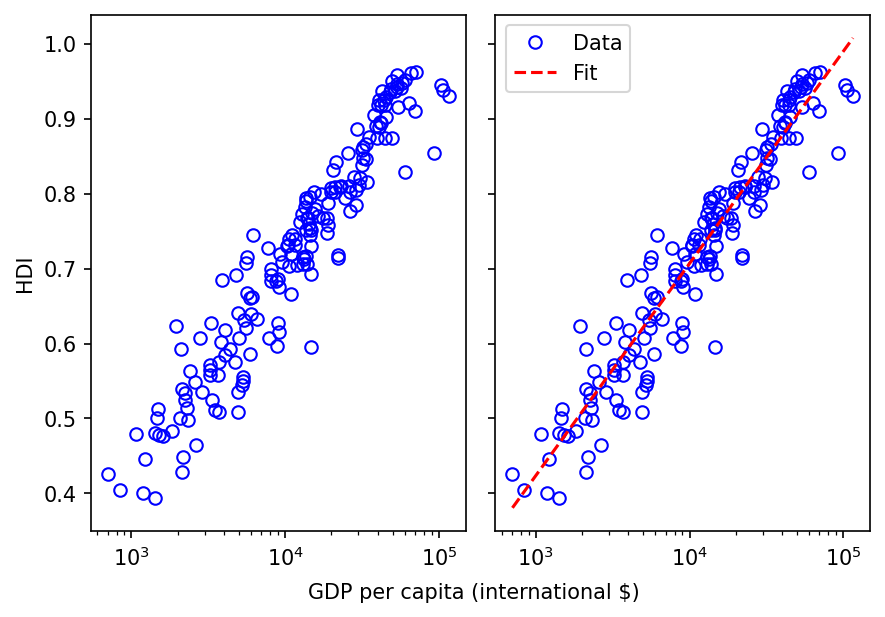

In [16]:
gdppc_ind = data_hdi.gdppc.argsort()
sorted_gdppc = data_hdi.gdppc[gdppc_ind]
sorted_hdi = data_hdi.HDI[gdppc_ind]

hdi_bestfit = -0.426 + 0.123*np.log(sorted_gdppc)

fig, ax = plt.subplots(nrows=1, ncols=2, dpi=150, sharey=True)

ax[0].plot(data_hdi.gdppc, data_hdi.HDI, 'bo', mfc='none')
ax[0].set_ylabel('HDI')
ax[0].set_xscale("log")
ax[1].plot(sorted_gdppc, sorted_hdi, 'bo', mfc='none',label="Data")
ax[1].plot(sorted_gdppc, hdi_bestfit,'--r',label="Fit")
ax[1].set_xscale("log")
ax[1].legend()
fig.text(0.35, 0, 'GDP per capita (international $)', va='center', rotation='horizontal')
fig.tight_layout()

With the logarithmic line of best fit, we can see clearly that HDI rises approximately logarithmically with GDP per capita. GDP per capita is very closely related to GNI (gross national income) per capita in both definition and calculation, and GNI per capita is one of the four quantitative factors that contribute to a country's HDI measurement. In fact, the correlation between GDP per capita and HDI is so strong in the figure above that we may (correctly) assume that the log of GNI is used in the [HDI calculation](https://hdr.undp.org/system/files/documents/technical-notes-calculating-human-development-indices.pdf) (to reflect the diminishing importance of income with increasing GNI).

### 3.2 Income: **Gross National Income (GNI)**
Access the GNI data [here](https://ourworldindata.org/grapher/gni-per-capita-vs-gdp-per-capita) from Our World in Data.

In [ ]:
# Visualise the relationship between GDP and GNI
fig, ax = plt.subplots(dpi=100)
ax.plot(data_gni.gdppc, data_gni.gni, 'ro', mfc='none')
ax.set_xlabel('GDP per capita (international $)')
ax.set_ylabel('GNI per capita (international $)')
plt.show()

### 3.3 Health: **Average life expectancy at birth**
Access the life expectancy data [here](https://ourworldindata.org/grapher/life-expectancy-vs-gdp-per-capita?tab=table&time=2019) from Our World in Data.

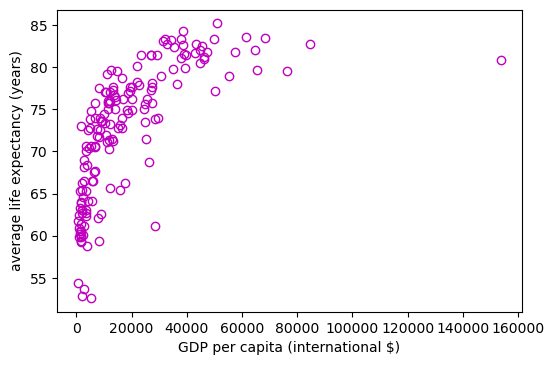

In [20]:
# Visualise the relationship between GDP and life expectancy
fig, ax = plt.subplots(dpi=100)
ax.plot(data_lifeexp.gdppc, data_lifeexp.life_exp, 'mo', mfc='none')
ax.set_xlabel('GDP per capita (international $)')
ax.set_ylabel('average life expectancy (years)')
plt.show()

It appears like there is a very high linear correlation between GDP per capita and average life expectancy for low-income countries, but almost no correlation at all for high-income countries. To investigate this, we can break up the data into lower-income and higher-income (truncated at a GDP per capita of 28,000 international $).

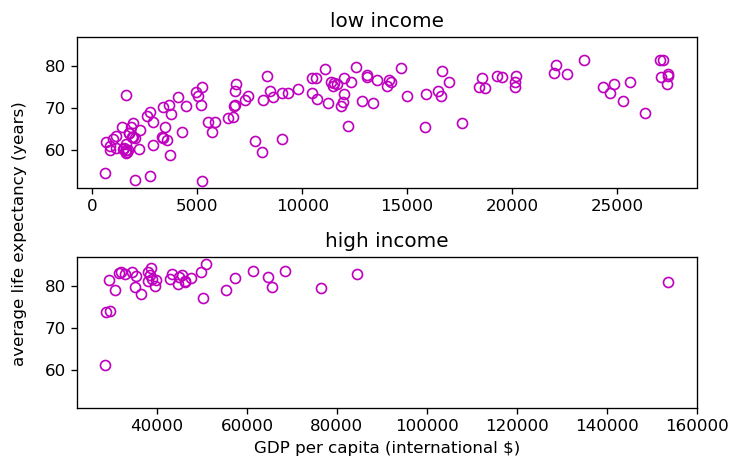

In [17]:
gdppc_lowincome = []; lifeexp_lowincome = [];
gdppc_highincome = []; lifeexp_highincome = [];

for i in range(len(data_lifeexp.gdppc)):
    if data_lifeexp.gdppc[i] < 28000:
        gdppc_lowincome.append(data_lifeexp.gdppc[i])
        lifeexp_lowincome.append(data_lifeexp.life_exp[i])
    else:
        gdppc_highincome.append(data_lifeexp.gdppc[i])
        lifeexp_highincome.append(data_lifeexp.life_exp[i])

fig, ax = plt.subplots(nrows=2, ncols=1, dpi=120, sharey=True)
ax[0].plot(gdppc_lowincome, lifeexp_lowincome, 'mo', mfc='none',label="Data")
ax[1].plot(gdppc_highincome, lifeexp_highincome, 'mo', mfc='none',label="Data")
ax[1].set_xlabel('GDP per capita (international $)')
ax[0].set_title('low income')
ax[1].set_title('high income')
fig.text(-0.02, 0.5, 'average life expectancy (years)', va='center', rotation='vertical')
fig.tight_layout()

plt.show()

We can see that there is a steadily-increasing relationship between GDP per capita and average life expectancy for low-income countries, and, as expected, almost no correlation at all for high-income countries. This is likely because many premature deaths in low-income countries are caused by preventable diseases such as malaria, HIV/AIDS, cholera and tuberculosis. Small increases in GDP per capita for low-income countries can provide individuals with improved accessibility and availability of treatments for these preventable diseases. For example, malaria treatment in Nigeria costs on average [32 USD per case](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5691839/), which requires a relatively small increase in GDP per capita for potentially life-saving treatment. Deaths in higher-income countries are often caused by non-preventable and/or lifestyle diseases (such as heart disease or cancer), which currently present the "biological limit" for humans (life expectancy of ~85 years).

### 3.4 Education: Average years of schooling
Access the mean number of schooling years data [here](https://ourworldindata.org/grapher/average-years-of-schooling-vs-gdp-per-capita) from Our World in Data.

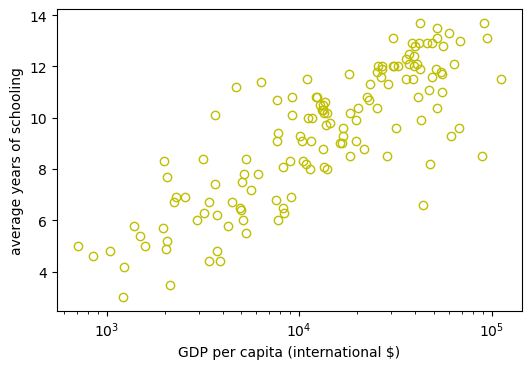

In [18]:
# Visualise relationship between energy consumption and GDP
fig, ax = plt.subplots(dpi=100)
ax.plot(data_education.gdppc, data_education.schooling, 'yo', mfc='none')
ax.set_xlabel('GDP per capita (international $)')
ax.set_ylabel('average years of schooling')
ax.set_xscale("log")
plt.show()

We can see that the relationship is fairly weak and especially poorly correlated for high-income countries (GDP per capita above 50,000 international $). Hence, above a certain GDP per capita, further expenditures on schooling do not neccessarily lead to a more educated population. We can visualise this by plotting the correlation for low-income and high-income countries.

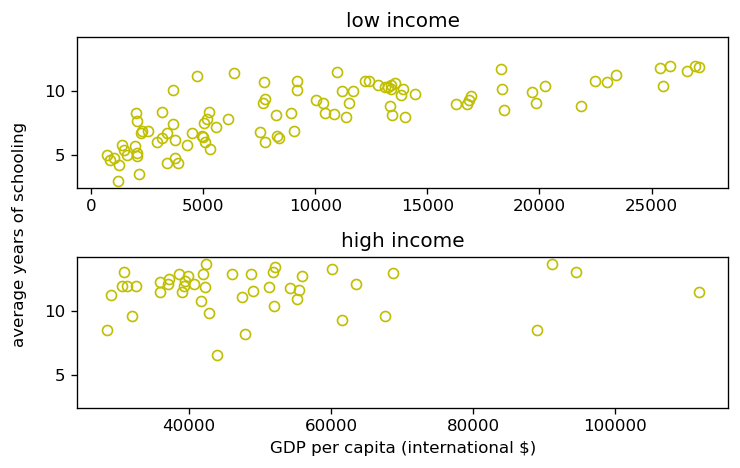

In [19]:
gdppc_lowincome = []; education_lowincome = [];
gdppc_highincome = []; education_highincome = [];

for i in range(len(data_education.gdppc)):
    if data_education.gdppc[i] < 28000:
        gdppc_lowincome.append(data_education.gdppc[i])
        education_lowincome.append(data_education.schooling[i])
    else:
        gdppc_highincome.append(data_education.gdppc[i])
        education_highincome.append(data_education.schooling[i])

fig, ax = plt.subplots(nrows=2, ncols=1, dpi=120, sharey=True)
ax[0].plot(gdppc_lowincome, education_lowincome, 'yo', mfc='none',label="Data")
ax[1].plot(gdppc_highincome, education_highincome, 'yo', mfc='none',label="Data")
ax[1].set_xlabel('GDP per capita (international $)')
ax[0].set_title('low income')
ax[1].set_title('high income')
fig.text(-0.02, 0.5, 'average years of schooling', va='center', rotation='vertical')
fig.tight_layout()

plt.show()

### 3.5 Energy: **Primary energy consumption**
The energy consumption against GDP per capita data is available from [Our World in Data](https://ourworldindata.org/grapher/energy-use-per-person-vs-gdp-per-capita). We will plot both the raw data as well as the data with a linear line of best fit. The graphs are displayed using both a log scale on the y-axis (top graphs), as well a regular linear scale (bottom graphs).

In [10]:
params, _ = scipy.optimize.curve_fit(lambda t,a,b: a+b*t,  data_energy.gdppc,  data_energy.eupc)
params

array([2.32370329e+03, 1.20148788e+00])

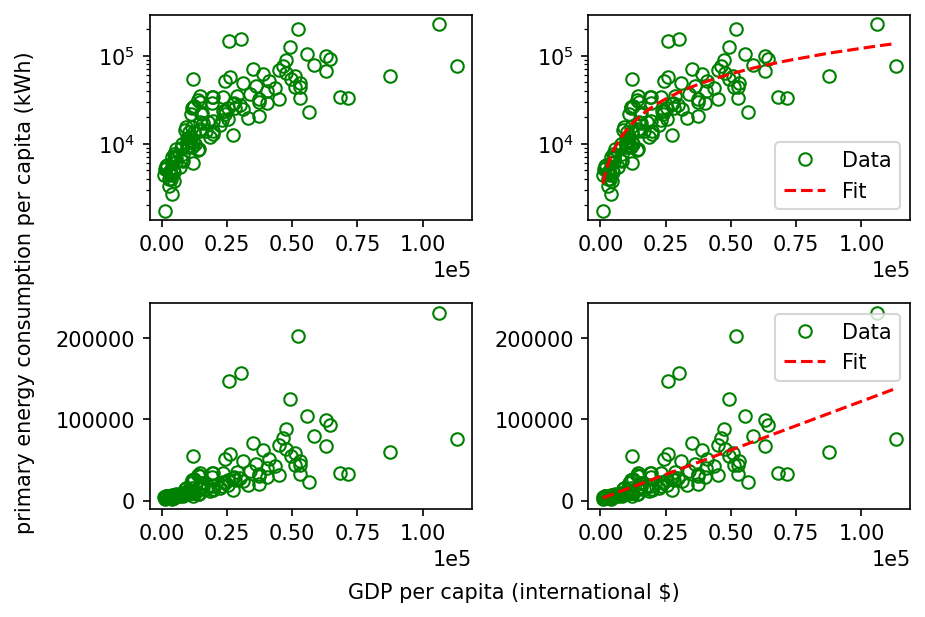

In [32]:
gdppc_ind = data_energy.gdppc.argsort()
sorted_gdppc = data_energy.gdppc[gdppc_ind]
sorted_energy = data_energy.eupc[gdppc_ind]

energy_bestfit = 2323.7 + 1.2*sorted_gdppc

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, dpi=150)

ax1.semilogy(data_energy.gdppc, data_energy.eupc, 'go', mfc='none')
ax1.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
ax2.semilogy(data_energy.gdppc, data_energy.eupc, 'go', mfc='none',label="Data")
ax2.semilogy(sorted_gdppc, energy_bestfit,'--r',label="Fit")
ax2.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
ax2.legend()

ax3.plot(data_energy.gdppc, data_energy.eupc, 'go', mfc='none')
ax3.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
ax4.plot(data_energy.gdppc, data_energy.eupc, 'go', mfc='none',label="Data")
ax4.plot(sorted_gdppc, energy_bestfit,'--r',label="Fit")
ax4.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
ax4.legend()

fig.text(0.35, 0, 'GDP per capita (international $)', va='center', rotation='horizontal')
fig.text(-0.02, 0.5, 'primary energy consumption per capita (kWh)', va='center', rotation='vertical')
fig.tight_layout()
plt.show()

We can add a residuals plot to extract information from the deviation from the line of best fit.

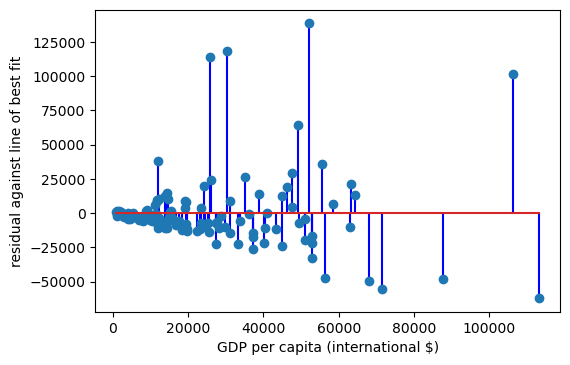

In [33]:
gdppc_energy_residual = sorted_energy - energy_bestfit

fig, ax = plt.subplots(dpi=100)
ax.stem(sorted_gdppc, gdppc_energy_residual, 'bo')
ax.set_xlabel('GDP per capita (international $)')
ax.set_ylabel('residual against line of best fit')
plt.show()

We can make some generalisations from this residuals plot. In general, the line of best fit tends to overestimate the true energy consumption per capita, which is likely due to several outstanding outliers in very high energy use for relatively low GDP per capita (Turkmenistan, Iceland, Russia, Kazakstan, UAE, Kuwait, Oman, Trinidad and Tobago). These countries are all rich in natural gas and oil, so we can see that the effect of GDP per capita on energy use may be overshadowed by natural resource abundance and quality (as well as government regulation).

### 3.6 Infant mortality: Child mortality rate
One further factor that we can investigate is the correlation between GDP per capita and child mortality rate (which is the number of infants whom die before the age of five). The data is available from [Our World in Data](https://ourworldindata.org/grapher/child-mortality-gdp-per-capita?tab=table&time=2018).

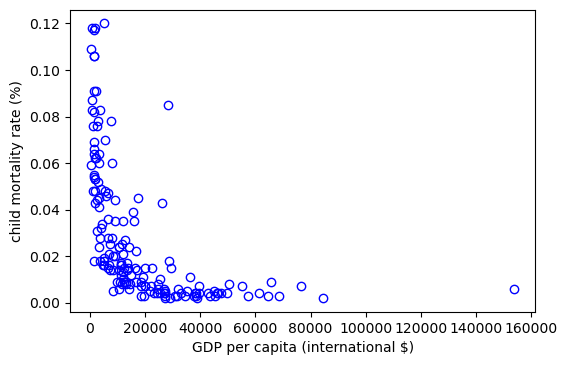

In [21]:
# Visualise relationship between GDP and child mortality rate
fig, ax = plt.subplots(dpi=100)
ax.plot(data_mortality.gdppc, data_mortality.rate, 'bo', mfc='none')
ax.set_xlabel('GDP per capita (international $)')
ax.set_ylabel('child mortality rate (%)')
plt.show()

From this data, we can see that, in general, child mortality decreases with increasing GDP per capita approximately  exponentially. This relationship is to be expected - better economic conditions create better health outcomes through better health care, more nutritious diets, and better health-related knowledge. Additionally, access to health personnel and health facilities such as midwifes, doctors, health posts and clinics would increase with higher GDP per capita, leading to less birth fatalities.

## 4. GDP and Enviroment


GDP sometimes disregards for the environmental costs of economic activities. GDP measures the market value of goods and services produced within a country without subtracting the negative externalities, such as:
- Pollution
- Resource depletion
- Global Warming
- Loss of biodiversity


This oversight means activities harming the environment can actually contribute to GDP growth, creating a perverse incentive structure that rewards short-term economic gains at the expense of long-term sustainability.  

### 4.1. Temperature Anomaly vs. World GDP

Consider the following diagram of Temperature Anomaly vs. World GDP

In [1]:
data = pd.read_excel('Temperature Anomaly.xlsx', sheet_name='Sheet2')

plt.figure(figsize=(10, 6))

ax1 = plt.gca() 
ax1.plot(data['Year'], data['GDP per Capita'], label='GDP per capita', color='indigo', marker='o')
ax1.set_xlabel('Year')
ax1.set_ylabel('GDP per Capita', color='blue')

ax2 = ax1.twinx()
ax2.plot(data['Year'], data['PAGES2k Consortium 2019 global mean temperature reconstructions'], label='PAGES2k Consortium 2019 global mean temperature reconstructions', color='salmon', marker='.')
ax2.plot(data['Year'], data['Climate Research Unit Record'], label='Climate Research Unit Record', color='lightblue', marker='.')
ax2.set_ylabel('Temperature Anomaly')

plt.title('GDP per Capita and Temperature Anomaly vs. Year')

lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines + lines2, labels + labels2, loc='upper left')
plt.show()


NameError: name 'pd' is not defined

Source: Climate Research Unit, Nature Geoscience, and Our World In Data

Temperature anomaly measures the difference between the temperature of the current year and the long-term average. A positive figure indicates that the temperature was warmer than the average value, and vice versa.

From 1500 to 2023, as GDP per Capita increases the golbal Temperature Anomaly increases as well. The relationship can be seen more clearly by plotting World GDP against Temperature Anomaly:

In [ ]:
data = pd.read_excel('GDP.xlsx', sheet_name='Temperature')

fig = px.scatter(data, x='World GDP', y='Temperature Anomaly',
                 hover_name='Year', title='Temperature Anomaly vs. World GDP')


fig.update_layout(
    xaxis_title="GDP ($ trillions)",
    yaxis_title="Temperature Anomaly(Degree C)",
    xaxis_gridcolor='lightgrey',
    yaxis_gridcolor='lightgrey',
)

fig.show()

Source: The World Bank and National Oceanic and Atmospheric Administration, Earth System Research Laboratory, Global Monitoring Division

In [ ]:
correlation = data['World GDP'].corr(data['Temperature Anomaly'])
print(f"The Pearson correlation coefficient is: {correlation}")

The graph shows more clearly that as the world GDP increases throughout the years, the temperature anomaly also tends to increase.

The Pearson correlation coefficient for this set of data is 0.9317515940963721, which indicates a very strong positive linear relationship between the temperature anomaly and the World GDP.

This could suggest that as economic activity (measured by GDP) increases, there is a corresponding increase in the average temperature anomaly, which could be interpreted as an indicator of global warming.

### 4.2. Ecological State (Temperature Anamoly & CO2 Emissions) vs. World GDP

In [ ]:
carbon_temp_gdp_df = pd.read_csv('carbon_temp_gdp_df.csv')

In [ ]:
carbon_temp_gdp_df.head()

In [ ]:
# Create a figure and axis objects with a larger figure size
fig, ax1 = plt.subplots(figsize=(12, 8))

# Plot the Temperature Anomaly columns
ax1.plot(carbon_temp_gdp_df['Year '], carbon_temp_gdp_df['Temperature Anomaly\n(deg C)'], color='red', label='Temperature Anomaly')
ax1.plot(carbon_temp_gdp_df['Year '], carbon_temp_gdp_df['Smoothed Temperature Anomaly\n(deg C)'], color='orange', label='Smoothed Temperature Anomaly')
ax1.set_ylabel('Temperature Anomaly (Degrees Celsius)')

# Create a second y-axis for total_gdp and annual CO₂ emissions
ax2 = ax1.twinx()
ax2.plot(carbon_temp_gdp_df['Year '], carbon_temp_gdp_df['total_gdp'], color='blue', label='Total GDP')
ax2.plot(carbon_temp_gdp_df['Year '], carbon_temp_gdp_df['Annual CO₂ emissions'], color='green', label='Annual CO₂ emissions')
ax2.set_ylabel('Total GDP (Billions) / Annual CO₂ emissions (Billions)')

# Set the labels and legends
ax1.set_xlabel('Year')
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')

# Display the graph
plt.title('Carbon Emissions, Temperature Anomaly, and Total GDP Over Time')
plt.show()